In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import random
import folium
from folium import plugins

#setting plot style to seaborn
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#set color pallette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 60.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=9caa2f25097b723df8ca93b670e83af26ce91654c4cbba71c389244994f57944
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [5]:
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Initialize geocoding package
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_request")

In [7]:
import os
import pyspark
conf = pyspark.SparkConf()

conf.set('spark.ui.proxyBase', '/user/' + 'proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', False)
conf.set('spark.driver.memory','4g')
sc= pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)

In [8]:
!unzip /content/drive/MyDrive/BigDataProject/citibike_trip_2021-22.zip -d /content/data/

Archive:  /content/drive/MyDrive/BigDataProject/citibike_trip_2021-22.zip
  inflating: /content/data/202210-citibike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202210-citibike-tripdata.csv  
  inflating: /content/data/202209-citibike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202209-citibike-tripdata.csv  
  inflating: /content/data/202208-citibike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202208-citibike-tripdata.csv  
  inflating: /content/data/202207-citbike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202207-citbike-tripdata.csv  
  inflating: /content/data/202206-citbike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202206-citbike-tripdata.csv  
  inflating: /content/data/202205-citibike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202205-citibike-tripdata.csv  
  inflating: /content/data/202204-citibike-tripdata.csv  
  inflating: /content/data/__MACOSX/._202204-citibike-tripdata.csv  
  inflating: /content/data/202203-citibik

In [9]:
#get list of files
path = '/content/data/'
dir_list = os.listdir(path)
dir_list.sort()
if dir_list[-1] == '__MACOSX':
  dir_list = dir_list[:-1]

dir_list

['202102-citibike-tripdata.csv',
 '202103-citibike-tripdata.csv',
 '202104-citibike-tripdata.csv',
 '202105-citibike-tripdata.csv',
 '202106-citibike-tripdata.csv',
 '202107-citibike-tripdata.csv',
 '202108-citibike-tripdata.csv',
 '202109-citibike-tripdata.csv',
 '202110-citibike-tripdata.csv',
 '202111-citibike-tripdata.csv',
 '202112-citibike-tripdata.csv',
 '202201-citibike-tripdata.csv',
 '202202-citibike-tripdata.csv',
 '202203-citibike-tripdata.csv',
 '202204-citibike-tripdata.csv',
 '202205-citibike-tripdata.csv',
 '202206-citbike-tripdata.csv',
 '202207-citbike-tripdata.csv',
 '202208-citibike-tripdata.csv',
 '202209-citibike-tripdata.csv',
 '202210-citibike-tripdata.csv']

In [10]:
filePaths =[path + fileName for fileName in dir_list]
filePaths

['/content/data/202102-citibike-tripdata.csv',
 '/content/data/202103-citibike-tripdata.csv',
 '/content/data/202104-citibike-tripdata.csv',
 '/content/data/202105-citibike-tripdata.csv',
 '/content/data/202106-citibike-tripdata.csv',
 '/content/data/202107-citibike-tripdata.csv',
 '/content/data/202108-citibike-tripdata.csv',
 '/content/data/202109-citibike-tripdata.csv',
 '/content/data/202110-citibike-tripdata.csv',
 '/content/data/202111-citibike-tripdata.csv',
 '/content/data/202112-citibike-tripdata.csv',
 '/content/data/202201-citibike-tripdata.csv',
 '/content/data/202202-citibike-tripdata.csv',
 '/content/data/202203-citibike-tripdata.csv',
 '/content/data/202204-citibike-tripdata.csv',
 '/content/data/202205-citibike-tripdata.csv',
 '/content/data/202206-citbike-tripdata.csv',
 '/content/data/202207-citbike-tripdata.csv',
 '/content/data/202208-citibike-tripdata.csv',
 '/content/data/202209-citibike-tripdata.csv',
 '/content/data/202210-citibike-tripdata.csv']

In [11]:
#Read Data
df = spark.read\
     .option('inferSchema', 'true')\
     .option('header', 'true')\
     .csv(filePaths)

In [12]:
#Print Shape of dataframe
print('Size of Data: ', (df.count(), len(df.columns)))

Size of Data:  (53146269, 13)


In [13]:
#remove nulls
df = df.na.drop("any")

In [14]:
#Check for null values
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|start_lng|end_lat|end_lng|member_casual|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|      0|            0|         0|       0|                 0|               0|               0|             0|        0|        0|      0|      0|            0|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+



In [13]:
#Print Shape of dataframe after removing nulls
print('Size of Data: ', (df.count(), len(df.columns)))

Size of Data:  (52989860, 13)


In [15]:
from pyspark.sql.types import IntegerType,BooleanType,DateType, TimestampType, DecimalType, StringType
from pyspark.sql.functions import udf, col, dayofweek, dayofmonth, dayofyear, hour, month, quarter, year, to_date, weekofyear

#define udf to reverse geolocate buroughs, counties, neighbourhoods
manhattan_neighbourhood_udf = udf(lambda lat, lng, b: geolocator.reverse([lat, lng])[0].split(', ')[-7] if b=='Manhattan'  else '', StringType())
burough_udf = udf(lambda lat, lng: geolocator.reverse([lat, lng])[0].split(', ')[-6], StringType())
county_udf = udf(lambda lat, lng: geolocator.reverse([lat, lng])[0].split(', ')[-5], StringType())
city_udf = udf(lambda lat, lng: geolocator.reverse([lat, lng])[0].split(', ')[-4], StringType())

#Convert Data types of locations and timestamps
df = df.withColumn("started_at",df.started_at.cast(TimestampType())) \
  .withColumn("ended_at",df.ended_at.cast(TimestampType())) \
  .withColumn("start_lat",df.start_lat.cast(DecimalType(20, 10))) \
  .withColumn("start_lng",df.start_lng.cast(DecimalType(20, 10))) \
  .withColumn("end_lat",df.end_lat.cast(DecimalType(20, 10))) \
  .withColumn("end_lng",df.end_lng.cast(DecimalType(20, 10))) \
  .withColumn("trip_duration",col('ended_at').cast('long') - col('started_at').cast('long')) \
  .withColumn("startBurough", burough_udf(col('start_lat'), col('start_lng'))) \
  .withColumn("startManhattanNeighbourhood", manhattan_neighbourhood_udf(col('start_lat'), col('start_lng'), col('startBurough'))) \
  .withColumn("startCounty", county_udf(col('start_lat'), col('start_lng'))) \
  .withColumn("startCity", city_udf(col('start_lat'), col('start_lng'))) \
  .withColumn("endBurough", burough_udf(col('end_lat'), col('end_lng'))) \
  .withColumn("endManhattanNeighbourhood", manhattan_neighbourhood_udf(col('end_lat'), col('end_lng'), col('endBurough'))) \
  .withColumn("endCounty", county_udf(col('end_lat'), col('end_lng'))) \
  .withColumn("endCity", city_udf(col('end_lat'), col('end_lng'))) \

#df.show(5) 

In [16]:
#Get informations from the start and end dates
df = df.withColumn("startDate", to_date(col('started_at'))) \
       .withColumn("startDOW", dayofweek(col('started_at'))) \
       .withColumn('startDOM', dayofmonth(col('started_at'))) \
       .withColumn('startDOY', dayofyear(col('started_at'))) \
       .withColumn('startHour', hour(col('started_at'))) \
       .withColumn('startMonth', month(col('started_at'))) \
       .withColumn('startQuarter', quarter(col('started_at'))) \
       .withColumn('startWOY', weekofyear(col('started_at'))) \
       .withColumn('startYear', year(col('ended_at'))) \
       .withColumn("endDate", to_date(col('ended_at'))) \
       .withColumn('endDOW', dayofweek(col('ended_at'))) \
       .withColumn('endDOM', dayofmonth(col('ended_at'))) \
       .withColumn('endDOY', dayofyear(col('ended_at'))) \
       .withColumn('endHour', hour(col('ended_at'))) \
       .withColumn('endMonth', month(col('ended_at'))) \
       .withColumn('endQuarter', quarter(col('ended_at'))) \
       .withColumn('endWOY', weekofyear(col('ended_at'))) \
       .withColumn('endYear', year(col('ended_at'))) 

In [17]:
#Refresh geolocator
geolocator = Nominatim(user_agent="my_request")

## Members vs Casual Riders

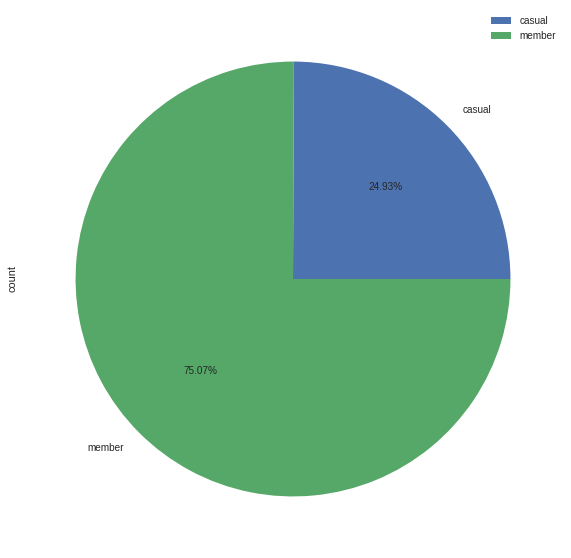

In [20]:
#get value counts of membership
mem_df = df.groupBy('member_casual').count().toPandas()

#Plot pie
mem_df.index = mem_df['member_casual']
plot = mem_df.plot.pie(y='count', figsize=(10, 10),autopct='%1.2f%%')

## Trip Duration

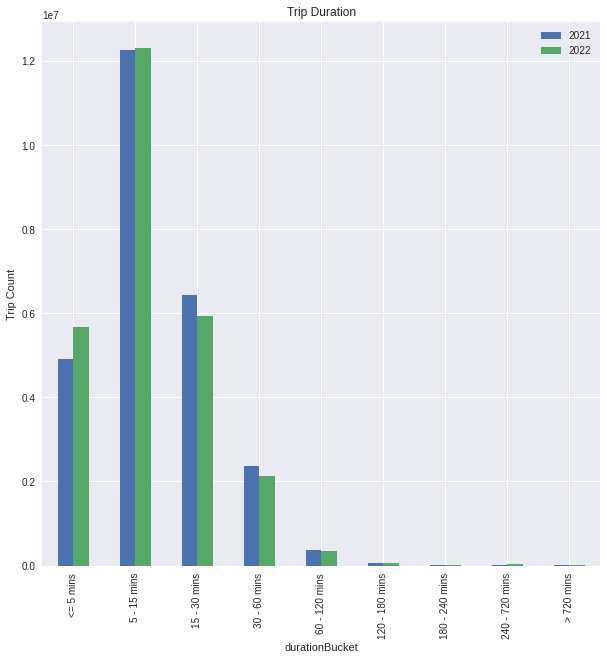

In [20]:
#udf to calculate buckets

def buckets(x):
  if x <= 5:
    return '<= 5 mins'
  elif x <= 15:
    return '5 - 15 mins'  
  elif x <= 30:
    return '15 - 30 mins'
  elif x <= 60:
    return '30 - 60 mins'
  elif x <= 120:
    return '60 - 120 mins'
  elif x <= 180:
    return '120 - 180 mins'
  elif x <= 240:
    return '180 - 240 mins'
  elif x <= 720:
    return '240 - 720 mins'
  elif x <= 99999999:
    return '> 720 mins'
  else:
    return 'None'

def duration(x):
  if x <= 5:
    return 5
  elif x <= 15:
    return 15  
  elif x <= 30:
    return 30
  elif x <= 60:
    return 60
  elif x <= 120:
    return 120
  elif x <= 180:
    return 180
  elif x <= 240:
    return 240
  elif x <= 720:
    return 720
  elif x <= 99999999:
    return 721
  else:
    return 'None'    

duration_bucket_udf =  udf(lambda dur: buckets(dur/60), StringType())
duration_udf =  udf(lambda dur: duration(dur/60), IntegerType())

duration_df = df.withColumn('tripDurationBucket', duration_bucket_udf(col('trip_duration'))) \
                .withColumn('duration', duration_udf(col('trip_duration'))) \
                .groupby('endYear', 'tripDurationBucket', 'duration').count().toPandas()




#Transform and Plot 
dur21 = duration_df[duration_df['endYear'] == 2021][['tripDurationBucket', 'duration', 'count']] \
        .rename(columns = {'tripDurationBucket':'durationBucket', 'duration':'duration', 'count':'2021'}) \
        .sort_values('duration')

dur22 = duration_df[duration_df['endYear'] == 2022][['tripDurationBucket', 'duration', 'count']] \
        .rename(columns = {'tripDurationBucket':'durationBucket', 'duration':'duration', 'count':'2022'}) \
        .sort_values('duration')

dur = dur21.merge(dur22, left_on='durationBucket', right_on='durationBucket')[['durationBucket', '2021', '2022']]

ax = dur.plot(x="durationBucket", y=['2021', '2022'], kind="bar", figsize=(10, 10), title = 'Trip Duration', ylabel = 'Trip Count')

## Same Start and End Locations

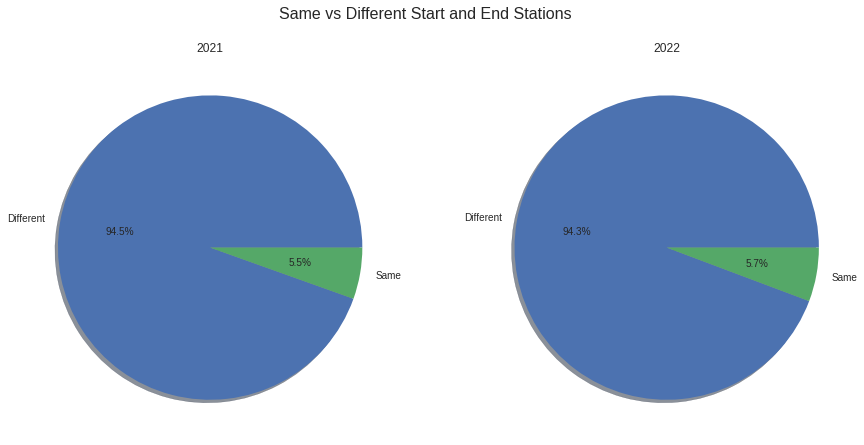

In [22]:
#Same start and end stations
sameStartEnd = udf(lambda st, end: 'Same' if st == end else 'Different', StringType())
sameStartEnd_df = df.withColumn('sameStartEnd', sameStartEnd(col('start_station_id'), col('end_station_id')))\
                    .groupBy('endYear', 'sameStartEnd').count().toPandas()

#get number of years
years = list(set(sameStartEnd_df['endYear'].sort_values().tolist()))

#create sublots
fig, axs = plt.subplots(1, len(years))
fig.suptitle('Same vs Different Start and End Stations', fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(15)

#Plot pie charts for each year
for i, year in enumerate(years):
  fracs = sameStartEnd_df[sameStartEnd_df['endYear'] == year]['count'].tolist()
  labels = sameStartEnd_df[sameStartEnd_df['endYear'] == year]['sameStartEnd'].tolist()

  axs[i].pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

  axs[i].set_title(year)

## Monthly Trends Total

In [40]:
from pyspark.sql.functions import sum, count, mean

# get data for each month for all years
month_df = df.groupBy('endYear', 'endMonth') \
             .agg(sum('trip_duration').alias('total_trip_duration'), \
                  mean('trip_duration').alias('avg_trip_duration'), \
                  count('ride_id').alias('count'))\
             .toPandas()\
             .sort_values(['endYear', 'endMonth'])

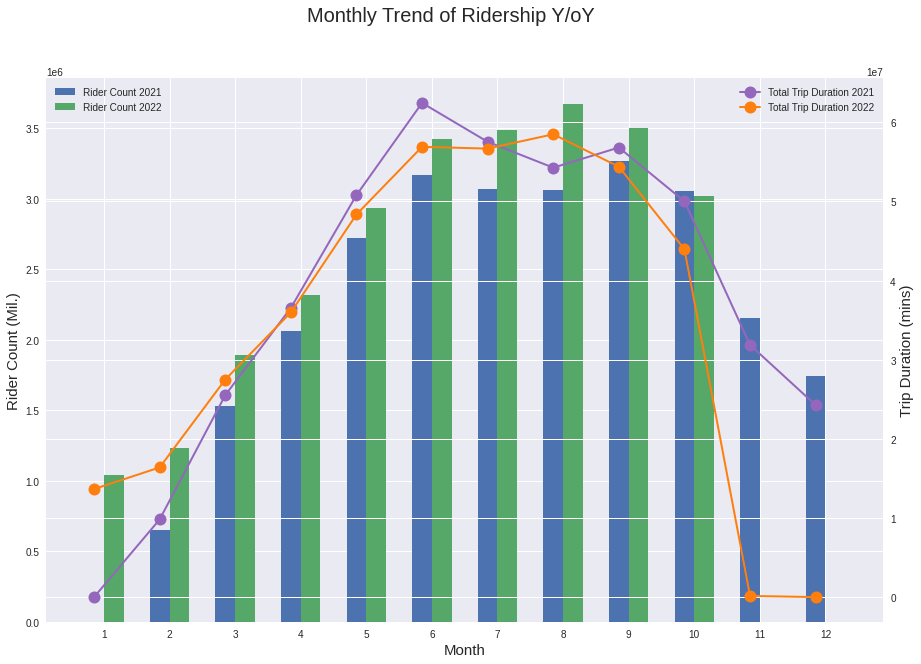

In [24]:
#get years and months
years = list(set(month_df['endYear'].tolist()))
months = list(set(month_df['endMonth'].tolist()))

#set figure
fig,ax=plt.subplots(figsize=(15,10))
fig.suptitle('Monthly Trend of Ridership Y/oY', fontsize = 20)
ax2=ax.twinx()

#set width of bar
width = 0.3

#loop through each year plot results
for i, year in enumerate(years):
  month_riders_data = month_df[month_df['endYear'] == year]['count'].tolist()
  month_trip_durations = (np.array(month_df[month_df['endYear'] == year]['total_trip_duration'].tolist())/60.0).tolist()
  month = month_df[month_df['endYear'] == year]['endMonth'].tolist()
  
  #replace missing values with 0
  for j, m in enumerate(months):
    if m not in month:
      month_riders_data.insert(j, 0)
      month_trip_durations.insert(j, 0)
  
  #add bar for trip count
  ax.bar(np.array(months) + i*width, height=month_riders_data, width = width, label='Rider Count ' + str(year))
  
  #add line for trip duration
  ax2.plot(months, 
           month_trip_durations, 
           label='Total Trip Duration ' + str(year), 
           color = colors[random.randint(0, len(colors)-1)], 
           marker='o', 
           linewidth=2, 
           markersize=12)

plt.xticks(np.array(months) + width / 2, months)

ax.set_ylabel('Rider Count (Mil.)', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax2.set_ylabel('Trip Duration (mins)', fontsize=15)
ax.legend(loc='upper left')
ax2.legend(loc='best')


# Monthly Trend Average

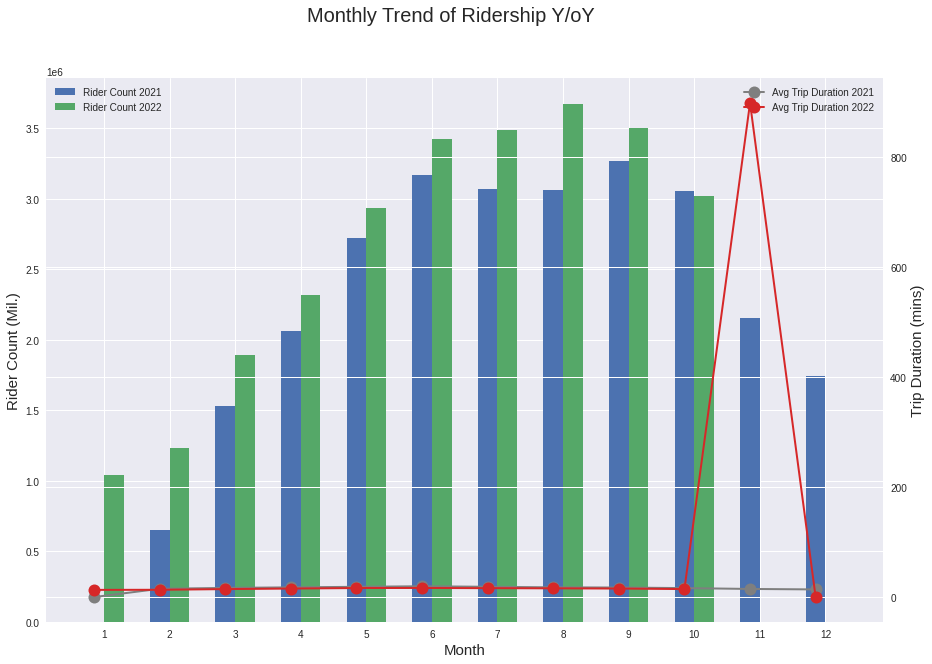

In [42]:
#get years and months
years = list(set(month_df['endYear'].tolist()))
months = list(set(month_df['endMonth'].tolist()))

#set figure
fig,ax=plt.subplots(figsize=(15,10))
fig.suptitle('Monthly Trend of Ridership Y/oY', fontsize = 20)
ax2=ax.twinx()

#set width of bar
width = 0.3

#loop through each year plot results
for i, year in enumerate(years):
  month_riders_data = month_df[month_df['endYear'] == year]['count'].tolist()
  month_trip_durations = (np.array(month_df[month_df['endYear'] == year]['avg_trip_duration'].tolist())/60.0).tolist()
  month = month_df[month_df['endYear'] == year]['endMonth'].tolist()
  
  #replace missing values with 0
  for j, m in enumerate(months):
    if m not in month:
      month_riders_data.insert(j, 0)
      month_trip_durations.insert(j, 0)
  
  #add bar for trip count
  ax.bar(np.array(months) + i*width, height=month_riders_data, width = width, label='Rider Count ' + str(year))
  
  #add line for trip duration
  ax2.plot(months, 
           month_trip_durations, 
           label='Avg Trip Duration ' + str(year), 
           color = colors[random.randint(0, len(colors)-1)], 
           marker='o', 
           linewidth=2, 
           markersize=12)

plt.xticks(np.array(months) + width / 2, months)

ax.set_ylabel('Rider Count (Mil.)', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax2.set_ylabel('Trip Duration (mins)', fontsize=15)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


# Hourly Trend Total

In [25]:
from pyspark.sql.functions import sum, count, mean

# get data for each hour for all years

hour_df = df.groupBy('endYear', 'endHour') \
            .agg(sum('trip_duration').alias('total_trip_duration'), \
                 mean('trip_duration').alias('avg_trip_duration'), \
                 count('ride_id').alias('count'))\
            .toPandas()\
            .sort_values(['endYear', 'endHour'])

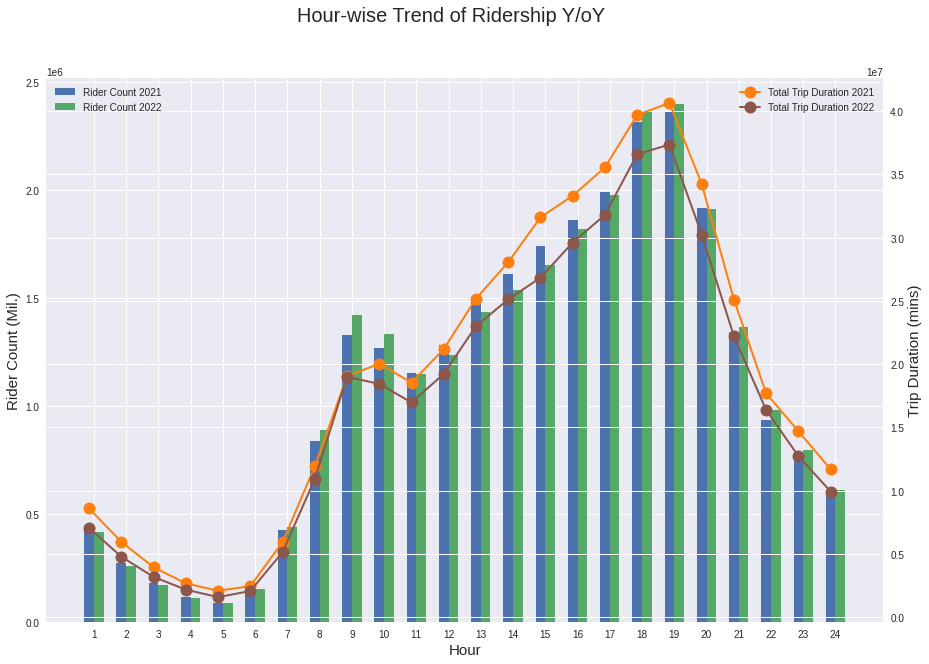

In [32]:
#get years and hour
years = list(set(hour_df['endYear'].tolist()))
hours = list(range(24))

#set figure
fig,ax=plt.subplots(figsize=(15,10))
fig.suptitle('Hour-wise Trend of Ridership Y/oY', fontsize = 20)
ax2=ax.twinx()

#set width of bar
width = 0.3

#loop through each year plot results
for i, year in enumerate(years):
  hour_riders_data = hour_df[hour_df['endYear'] == year]['count'].tolist()
  hour_trip_durations = (np.array(hour_df[hour_df['endYear'] == year]['total_trip_duration'].tolist())/60.0).tolist()
  hour = hour_df[hour_df['endYear'] == year]['endHour'].tolist()
  
  #replace missing values with 0
  for j, h in enumerate(hours):
    if h not in hour:
      hour_riders_data.insert(j, 0)
      hour_trip_durations.insert(j, 0)
  
  #add bar for trip count
  ax.bar(np.array(hours) + i*width, height=hour_riders_data, width = width, label='Rider Count ' + str(year))
  
  #add line for trip duration
  ax2.plot(hours, 
           hour_trip_durations, 
           label='Total Trip Duration ' + str(year), 
           color = colors[random.randint(0, len(colors)-1)], 
           marker='o', 
           linewidth=2, 
           markersize=12)

plt.xticks(np.array(hours) + width / 2, list(np.array(hours)+1))

ax.set_ylabel('Rider Count (Mil.)', fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax2.set_ylabel('Trip Duration (mins)', fontsize=15)
ax.legend(loc='upper left')
ax2.legend(loc='best')

plt.savefig('/content/drive/MyDrive/BigDataProject/yoy_TODRidership.png')
plt.show()

#Hourly Trend Average

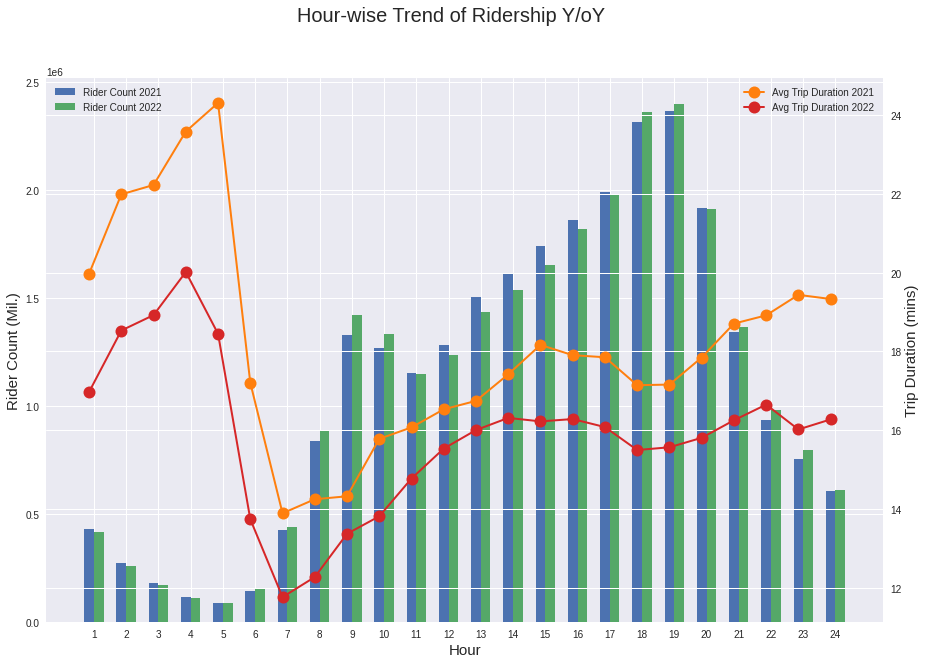

In [39]:
#get years and hour
years = list(set(hour_df['endYear'].tolist()))
hours = list(range(24))

#set figure
fig,ax=plt.subplots(figsize=(15,10))
fig.suptitle('Hour-wise Trend of Ridership Y/oY', fontsize = 20)
ax2=ax.twinx()

#set width of bar
width = 0.3

#loop through each year plot results
for i, year in enumerate(years):
  hour_riders_data = hour_df[hour_df['endYear'] == year]['count'].tolist()
  hour_trip_durations = (np.array(hour_df[hour_df['endYear'] == year]['avg_trip_duration'].tolist())/60.0).tolist()
  hour = hour_df[hour_df['endYear'] == year]['endHour'].tolist()
  
  #replace missing values with 0
  for j, h in enumerate(hours):
    if h not in hour:
      hour_riders_data.insert(j, 0)
      hour_trip_durations.insert(j, 0)
  
  #add bar for trip count
  ax.bar(np.array(hours) + i*width, height=hour_riders_data, width = width, label='Rider Count ' + str(year))
  
  #add line for trip duration
  ax2.plot(hours, 
           hour_trip_durations, 
           label='Avg Trip Duration ' + str(year), 
           color = colors[random.randint(0, len(colors)-1)], 
           marker='o', 
           linewidth=2, 
           markersize=12)

plt.xticks(np.array(hours) + width / 2, list(np.array(hours)+1))

ax.set_ylabel('Rider Count (Mil.)', fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax2.set_ylabel('Trip Duration (mins)', fontsize=15)
ax.legend(loc='upper left')
ax2.legend(loc='best')

# plt.savefig('/content/drive/MyDrive/BigDataProject/yoy_TODRidership.png')
plt.show()

##Top Start Stations Y/oY

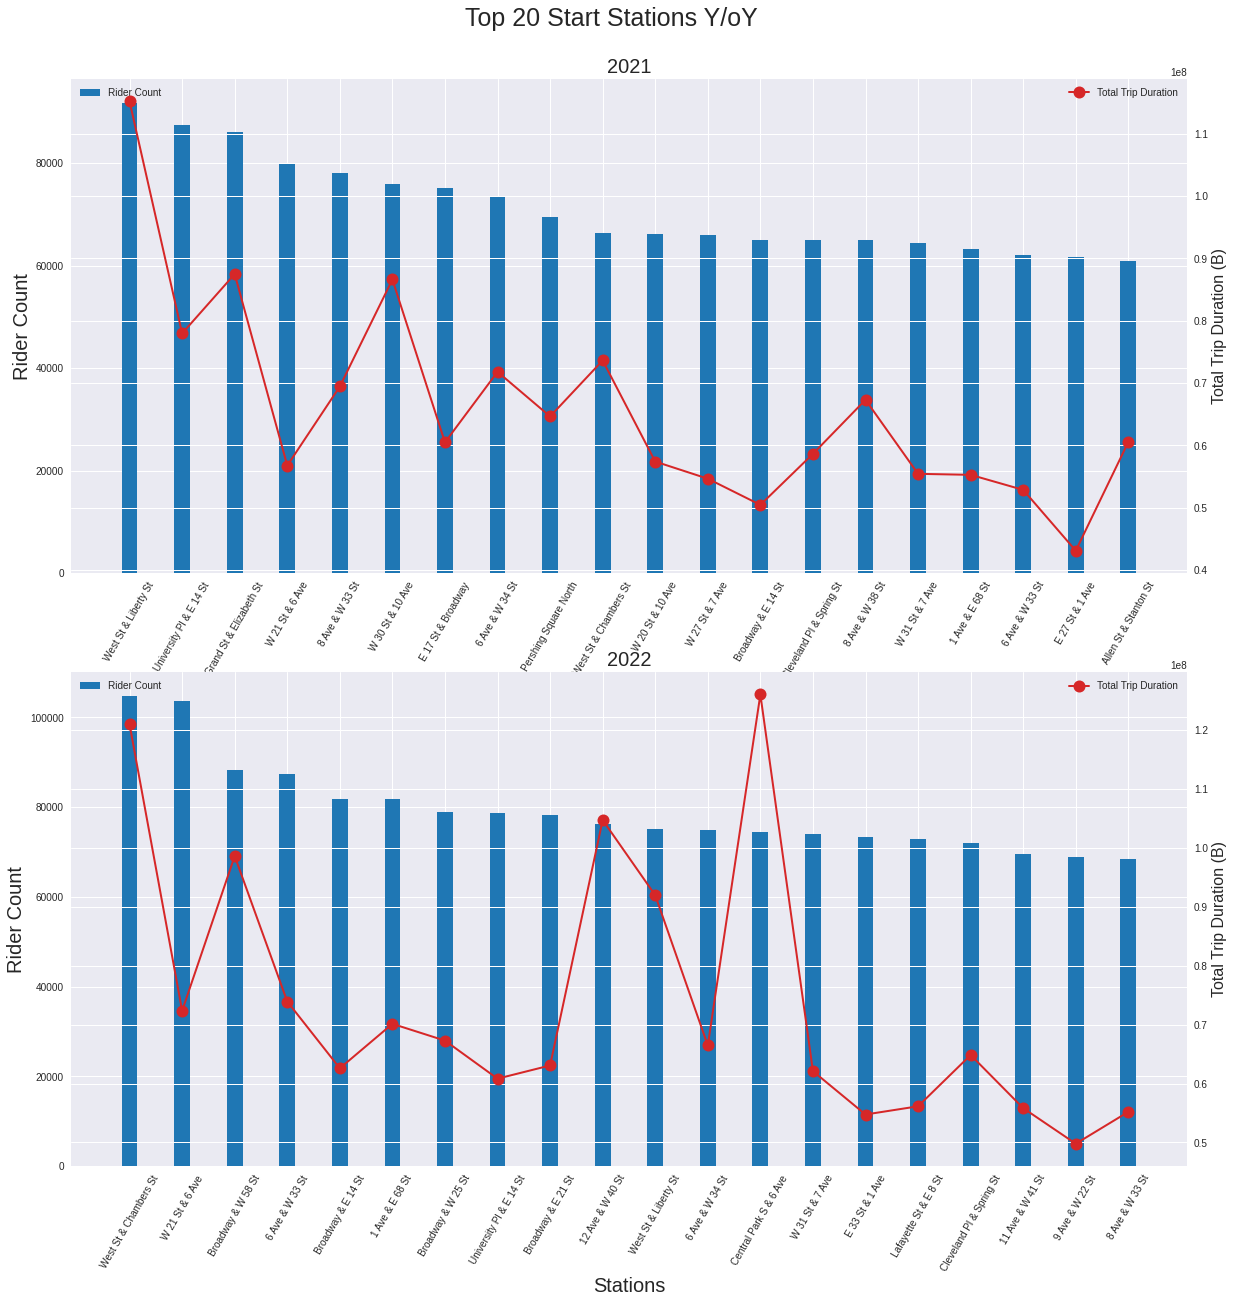

In [43]:
from pyspark.sql.functions import sum, count, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank

#Define window function
windowSpec  = Window.partitionBy("startYear").orderBy(col("num_trips").desc())

#Get Station Ridership counts for each year, and station
startStationRidership = df.select("ride_id", "start_station_name", "start_lng", "start_lat", "startYear", "trip_duration")\
                          .groupby("startYear", "start_station_name", "start_lng", "start_lat") \
                          .agg(sum('trip_duration').alias('total_trip_duration'), \
                                mean('trip_duration').alias('avg_trip_duration'), \
                                count('ride_id').alias('num_trips')) \
                          .withColumn('stationTripRank', row_number().over(windowSpec)) \
                          .toPandas() \
                          .sort_values(['startYear', 'stationTripRank'])


#set width of bar
width = 0.3

#Set number of top stations needed
top = 20

#create sublots
fig, axs = plt.subplots(len(years), figsize=(20, 20))
fig.suptitle('Top ' + str(top) + ' Start Stations Y/oY', fontsize = 25, y = 0.93)
#fig.set_figheight(7)
#fig.set_figwidth(15)


for i, year in enumerate(years):
  
  # if i > 0:
  #   box = axs[i].get_position()
  #   box.y0 = box.y0 - 0.05
  #   box.y1 = box.y1 - 0.05
  #   axs[i].set_position(box)


  #Get top stations for given year
  topStations = startStationRidership.loc[(startStationRidership.startYear == year) & (startStationRidership.stationTripRank <= top)]

  #Configure axes
  axs[i].set_title(year, fontsize = 20)
  ax2=axs[i].twinx()

  #plot num_trips
  axs[i].bar(np.array(range(top)), 
             height=topStations['num_trips'].tolist(),
             width = width,
             label='Rider Count',
             color='#1f77b4')



  #add line for trip duration
  ax2.plot(topStations['start_station_name'].tolist(), 
           topStations['total_trip_duration'].tolist(), 
           label='Total Trip Duration', 
           color = '#d62728', 
           marker='o', 
           linewidth=2, 
           markersize=12)

  #Set the xLabel and ticks
  axs[i].set_xlabel('Stations', fontsize = 20)
  axs[i].set_xticks(ticks = np.array(range(top))) # + width/2)  
  axs[i].set_xticklabels(topStations['start_station_name'].tolist(), rotation = 60, fontsize = 10)

  #Set y labels
  axs[i].set_ylabel('Rider Count', fontsize = 20)
  ax2.set_ylabel('Total Trip Duration (B)', fontsize = 16)

  #set legend
  axs[i].legend(loc='upper left')
  ax2.legend(loc='upper right')

plt.savefig('/content/drive/MyDrive/BigDataProject/yoy_topstartstations.png')
plt.show()

In [158]:
#Plot 2021 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top Start Stations you want to visualize: '))

  #Filter Data based on input
  tmp = startStationRidership.loc[(startStationRidership.startYear == year) & (startStationRidership.stationTripRank <= topRank)].reset_index(drop = True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['start_lat']
  longs = tmp['start_lng']
  names = tmp['start_station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top {topRank} Start Stations of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]}  
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Trips initiated in {year}</b>:\n{numTrips[i]} 
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(avgDur[i]/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2021
Enter Number of top Start Stations you want to visualize: 22


In [159]:
#Plot 2022 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top Start Stations you want to visualize: '))

  #Filter Data based on input
  tmp = startStationRidership.loc[(startStationRidership.startYear == year) & (startStationRidership.stationTripRank <= topRank)].reset_index(drop = True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['start_lat']
  longs = tmp['start_lng']
  names = tmp['start_station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top {topRank} Start Stations of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]} 
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Trips initiated in {year}</b>:\n{numTrips[i]}
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(avgDur[i]/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2022
Enter Number of top Start Stations you want to visualize: 20


In [160]:
#Plot YoY Comparison on Map
try:

  # year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top Start Stations you want to visualize: '))

  #Filter Data based on input for 2021
  tmp21 = startStationRidership.loc[(startStationRidership.startYear == 2021) & (startStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats21 = tmp21['start_lat']
  longs21 = tmp21['start_lng']
  names21 = tmp21['start_station_name']
  numTrips21 = tmp21['num_trips']
  totalDur21 = tmp21['total_trip_duration']
  avgDur21 = tmp21['avg_trip_duration']
  rank21 = tmp21['stationTripRank']
  colors21 = pd.cut(tmp21['num_trips'], bins=3, labels=['lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places21 = [[x[0],x[1]] for x in zip(lats21,longs21)]


  #Filter Data based on input for 2022
  tmp22 = startStationRidership.loc[(startStationRidership.startYear == 2022) & (startStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats22 = tmp22['start_lat']
  longs22 = tmp22['start_lng']
  names22 = tmp22['start_station_name']
  numTrips22 = tmp22['num_trips']
  totalDur22 = tmp22['total_trip_duration']
  avgDur22 = tmp22['avg_trip_duration']
  rank22 = tmp22['stationTripRank']
  colors22 = pd.cut(tmp22['num_trips'], bins=3, labels=['lightgreen', 'green', 'darkgreen']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places22 = [[x[0],x[1]] for x in zip(lats22,longs22)]

  #Render map using first station in list
  map = folium.Map(places21[random.randint(0, len(places21)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>YoY Comparison of Top {topRank} Start Stations</b></h3>'))

  #Plot and label each subsequent station for 2021
  for i, loc in enumerate(places21[1:]):
      #Define popup
      popup1 = folium.Popup(f'''<b>Year</b>: 2021
                                <br><b>Station</b>: {names21[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]}
                                <br><b>Trips initiated</b>:{numTrips21[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur21[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(avgDur21[i]/60.0)} mins''', 
                            min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors21[i]), popup=popup1).add_to(map)

  #Plot and label each station for 2022
  for i, loc in enumerate(places22):
      #Define popup
      popup2 = folium.Popup(f'''<b>Year</b>: 2022
                                <br><b>Station</b>: {names22[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]} 
                                <br><b>Trips initiated</b>: {numTrips22[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur22[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(avgDur22[i]/60.0)} mins''', 
                            min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors22[i]), popup=popup2).add_to(map)

  # Render map
  display(map)
except:
  print('Invalid Input')

Enter Number of top Start Stations you want to visualize: 20


## Top End Stations Y/oY

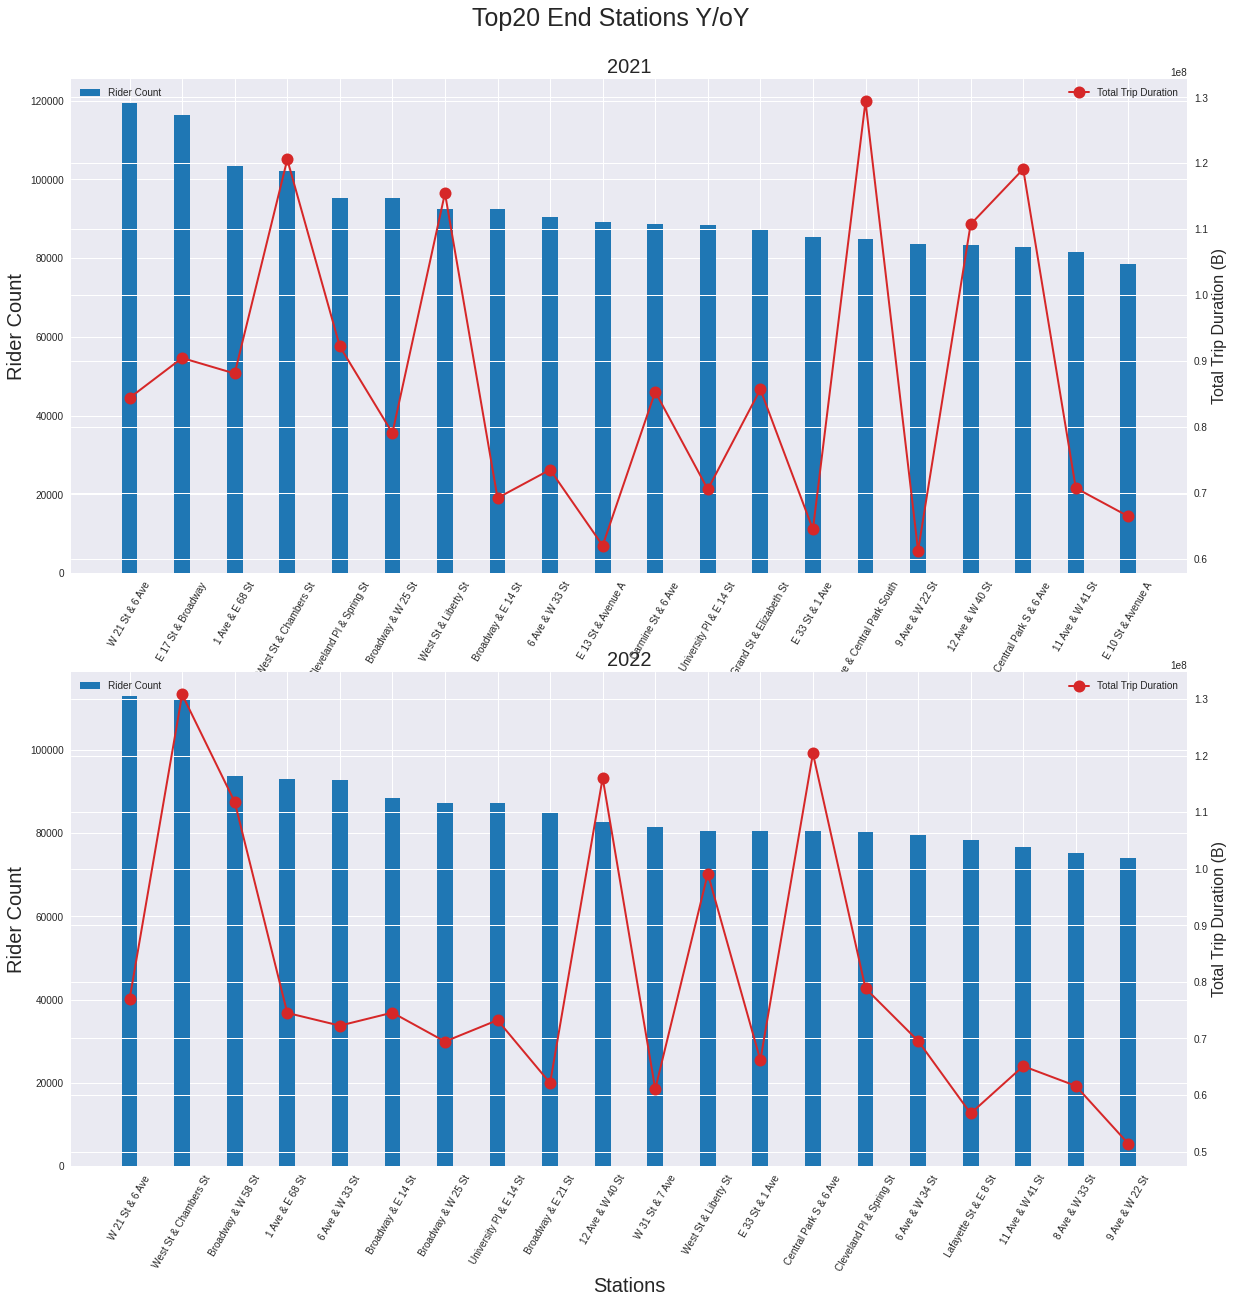

In [167]:
from pyspark.sql.functions import sum, count, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank

#Define window function
windowSpec  = Window.partitionBy("endYear").orderBy(col("num_trips").desc())

#Get Station Ridership counts for each year, and station
endStationRidership = df.select("ride_id", "end_station_name", "end_lng", "end_lat", "endYear", "trip_duration")\
                     .groupby("endYear", "end_station_name", "end_lng", "end_lat") \
                     .agg(sum('trip_duration').alias('total_trip_duration'), \
                          mean('trip_duration').alias('avg_trip_duration'), \
                          count('ride_id').alias('num_trips')) \
                     .withColumn('stationTripRank', row_number().over(windowSpec)) \
                     .toPandas() \
                     .sort_values(['endYear', 'stationTripRank'])


#set width of bar
width = 0.3

#Set number of top stations needed
top = 20

#create sublots
fig, axs = plt.subplots(len(years), figsize=(20, 20))
fig.suptitle('Top' + str(top) + ' End Stations Y/oY', fontsize = 25, y = 0.93)
#fig.set_figheight(7)
#fig.set_figwidth(15)


for i, year in enumerate(years):
  
  # if i > 0:
  #   box = axs[i].get_position()
  #   box.y0 = box.y0 - 0.05
  #   box.y1 = box.y1 - 0.05
  #   axs[i].set_position(box)


  #Get top stations for given year
  topStations = endStationRidership.loc[(endStationRidership.endYear == year) & (endStationRidership.stationTripRank <= top)]

  #Configure axes
  axs[i].set_title(year, fontsize = 20)
  ax2=axs[i].twinx()

  #plot num_trips
  axs[i].bar(np.array(range(top)), 
             height=topStations['num_trips'].tolist(),
             width = width,
             label='Rider Count',
             color='#1f77b4')



  #add line for trip duration
  ax2.plot(topStations['end_station_name'].tolist(), 
           topStations['total_trip_duration'].tolist(), 
           label='Total Trip Duration', 
           color = '#d62728', 
           marker='o', 
           linewidth=2, 
           markersize=12)

  #Set the xLabel and ticks
  axs[i].set_xlabel('Stations', fontsize = 20)
  axs[i].set_xticks(ticks = np.array(range(top))) # + width/2)  
  axs[i].set_xticklabels(topStations['end_station_name'].tolist(), rotation = 60, fontsize = 10)

  #Set y labels
  axs[i].set_ylabel('Rider Count', fontsize = 20)
  ax2.set_ylabel('Total Trip Duration (B)', fontsize = 16)

  #set legend
  axs[i].legend(loc='upper left')
  ax2.legend(loc='upper right')

plt.savefig('/content/drive/MyDrive/BigDataProject/yoy_topEndStations.png')
plt.show()

In [162]:
#Plot 2021 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input
  tmp = endStationRidership.loc[(endStationRidership.endYear == year) & (endStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['end_lat']
  longs = tmp['end_lng']
  names = tmp['end_station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top End Stations of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]}  
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Trips culminated in {year}</b>:\n{numTrips[i]} 
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(avgDur[i]/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2021
Enter Number of top End Stations you want to visualize: 20


In [165]:
#Plot 2022 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input
  tmp = endStationRidership.loc[(endStationRidership.endYear == year) & (endStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['end_lat']
  longs = tmp['end_lng']
  names = tmp['end_station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top End Stations of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]}  
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Trips culminated in {year}</b>:\n{numTrips[i]} 
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(avgDur[i]/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2022
Enter Number of top End Stations you want to visualize: 20


In [166]:
#Plot YoY Comparison on Map
try:

  # year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input for 2021
  tmp21 = endStationRidership.loc[(endStationRidership.endYear == 2021) & (endStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats21 = tmp21['end_lat']
  longs21 = tmp21['end_lng']
  names21 = tmp21['end_station_name']
  numTrips21 = tmp21['num_trips']
  totalDur21 = tmp21['total_trip_duration']
  avgDur21 = tmp21['avg_trip_duration']
  rank21 = tmp21['stationTripRank']
  colors21 = pd.cut(tmp21['num_trips'], bins=3, labels=['lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places21 = [[x[0],x[1]] for x in zip(lats21,longs21)]


  #Filter Data based on input for 2022
  tmp22 = endStationRidership.loc[(endStationRidership.endYear == 2022) & (endStationRidership.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats22 = tmp22['end_lat']
  longs22 = tmp22['end_lng']
  names22 = tmp22['end_station_name']
  numTrips22 = tmp22['num_trips']
  totalDur22 = tmp22['total_trip_duration']
  avgDur22 = tmp22['avg_trip_duration']
  rank22 = tmp22['stationTripRank']
  colors22 = pd.cut(tmp22['num_trips'], bins=3, labels=['lightgreen', 'green', 'darkgreen']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places22 = [[x[0],x[1]] for x in zip(lats22,longs22)]

  #Render map using first station in list
  map = folium.Map(places21[random.randint(0, len(places21)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>YoY Comparison of Top End Stations</b></h3>'))

  #Plot and label each subsequent station for 2021
  for i, loc in enumerate(places21[1:]):
      #Define popup
      popup1 = folium.Popup(f'''<b>Year</b>: 2021
                                <br><b>Station</b>: {names21[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]}
                                <br><b>Trips culminated in</b>:{numTrips21[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur21[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(avgDur21[i]/60.0)} mins''', 
                            min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors21[i]), popup=popup1).add_to(map)

  #Plot and label each station for 2022
  for i, loc in enumerate(places22):
      #Define popup
      popup2 = folium.Popup(f'''<b>Year</b>: 2022
                                <br><b>Station</b>: {names22[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]} 
                                <br><b>Trips culminated in</b>: {numTrips22[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur22[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(avgDur22[i]/60.0)} mins''', 
                            min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors22[i]), popup=popup2).add_to(map)

  # Render map
  display(map)
except:
  print('Invalid Input')

Enter Number of top End Stations you want to visualize: 20


## Top Stations (Total) Y/oY

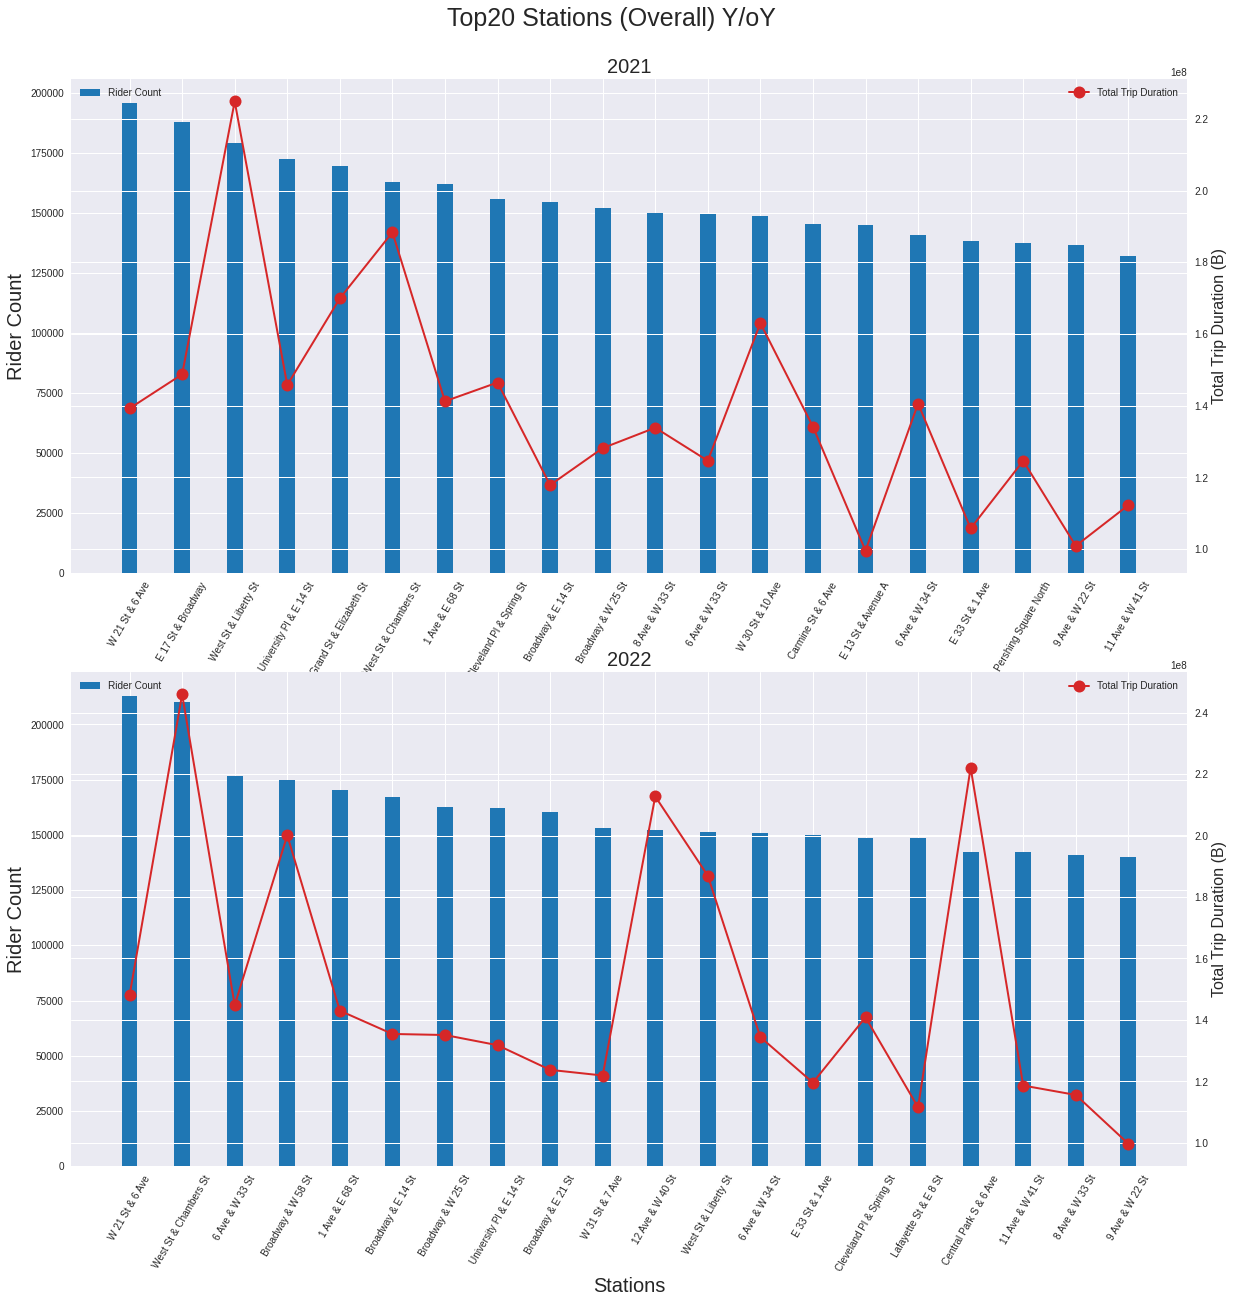

In [200]:
from pyspark.sql.functions import sum, count, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import col,isnan, when, count

#Get trips starting from each stations which end at a different station
startStationTrips = df.select("ride_id", \
                              col("start_station_name").alias('station_name'), \
                              col("start_lng").alias('lng'), \
                              col("start_lat").alias('lat'), \
                              col("startYear").alias('year'), \
                              "trip_duration" \
                      ) \
                      .filter(col('start_station_name') != col('end_station_name'))

#Get trips ending at each stations which start at a different station
endStationTrips = df.select("ride_id", \
                              col("end_station_name").alias('station_name'), \
                              col("end_lng").alias('lng'), \
                              col("end_lat").alias('lat'), \
                              col("endYear").alias('year'), \
                              "trip_duration" \
                    )\
                    .filter(col('start_station_name') != col('end_station_name'))

#Get trips which start and end at same station
circularTrips = df.select("ride_id", \
                              col("start_station_name").alias('station_name'), \
                              col("start_lng").alias('lng'), \
                              col("start_lat").alias('lat'), \
                              col("startYear").alias('year'), \
                              "trip_duration" \
                      ) \
                      .filter(col('start_station_name') == col('end_station_name')) \
                      .groupby('station_name', 'lat', 'lng', 'year') \
                      .agg(sum('trip_duration').alias('total_trip_duration_c'), \
                           mean('trip_duration').alias('avg_trip_duration_c'), \
                           count('ride_id').alias('num_trips_c'))

# Take union of start and end trips
singleStationTrips = startStationTrips.union(endStationTrips)
#Group and aggregate based on station, and year
singleStationTrips = singleStationTrips.groupby('station_name', 'lng', 'lat', 'year') \
                                       .agg(sum('trip_duration').alias('total_trip_duration_nc'), \
                                            mean('trip_duration').alias('avg_trip_duration_nc'), \
                                            count('ride_id').alias('num_trips_nc'))
                 
#join single station trips with circular trips
totalStationTrips = singleStationTrips.join(circularTrips, 
                                            (singleStationTrips.station_name == circularTrips.station_name) \
                                            & (singleStationTrips.lng == circularTrips.lng) \
                                            & (singleStationTrips.lat == circularTrips.lat) \
                                            & (singleStationTrips.year == circularTrips.year), \
                                            'left_outer') \
                                      .drop(circularTrips.station_name) \
                                      .drop(circularTrips.lng) \
                                      .drop(circularTrips.lat) \
                                      .drop(circularTrips.year)


#Define window function
windowSpec  = Window.partitionBy("year").orderBy(col("num_trips").desc())

#Fill na values after join and calculate total duration, avg, and total rides
totalStationTrips = totalStationTrips.na.fill(value=0,subset=["total_trip_duration_c", 'avg_trip_duration_c', 'num_trips_c']) \
                                     .withColumn('num_trips', col('num_trips_nc') + col('num_trips_c')) \
                                     .withColumn('total_trip_duration', col('total_trip_duration_nc') + col('total_trip_duration_c')) \
                                     .withColumn('avg_trip_duration', (col('total_trip_duration_nc') + col('total_trip_duration_c'))/col('num_trips').cast(DecimalType())) \
                                     .select('station_name', 'lng', 'lat', 'year', 'num_trips', 'total_trip_duration', 'avg_trip_duration') \
                                     .withColumn('stationTripRank', row_number().over(windowSpec)) \
                                     .toPandas() \
                                     .sort_values(['year', 'stationTripRank'])



#set width of bar
width = 0.3

#Set number of top stations needed
top = 20

#create sublots
fig, axs = plt.subplots(len(years), figsize=(20, 20))
fig.suptitle('Top' + str(top) + ' Stations (Overall) Y/oY', fontsize = 25, y = 0.93)
#fig.set_figheight(7)
#fig.set_figwidth(15)


for i, year in enumerate(years):
  
  # if i > 0:
  #   box = axs[i].get_position()
  #   box.y0 = box.y0 - 0.05
  #   box.y1 = box.y1 - 0.05
  #   axs[i].set_position(box)


  #Get top stations for given year
  topStations = totalStationTrips.loc[(totalStationTrips.year == year) & (totalStationTrips.stationTripRank <= top)]

  #Configure axes
  axs[i].set_title(year, fontsize = 20)
  ax2=axs[i].twinx()

  #plot num_trips
  axs[i].bar(np.array(range(top)), 
             height=topStations['num_trips'].tolist(),
             width = width,
             label='Rider Count',
             color='#1f77b4')



  #add line for trip duration
  ax2.plot(topStations['station_name'].tolist(), 
           topStations['total_trip_duration'].tolist(), 
           label='Total Trip Duration', 
           color = '#d62728', 
           marker='o', 
           linewidth=2, 
           markersize=12)

  #Set the xLabel and ticks
  axs[i].set_xlabel('Stations', fontsize = 20)
  axs[i].set_xticks(ticks = np.array(range(top))) # + width/2)  
  axs[i].set_xticklabels(topStations['station_name'].tolist(), rotation = 60, fontsize = 10)

  #Set y labels
  axs[i].set_ylabel('Rider Count', fontsize = 20)
  ax2.set_ylabel('Total Trip Duration (B)', fontsize = 16)

  #set legend
  axs[i].legend(loc='upper left')
  ax2.legend(loc='upper right')

plt.savefig(f'/content/drive/MyDrive/BigDataProject/yoy_top{top}Stations.png')
plt.show()

In [209]:
#Plot 2021 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input
  tmp = totalStationTrips.loc[(totalStationTrips.year == year) & (totalStationTrips.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['lat']
  longs = tmp['lng']
  names = tmp['station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top Stations (Overall) of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]}  
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Total Trips in {year}</b>:\n{numTrips[i]} 
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(float(avgDur[i])/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2021
Enter Number of top End Stations you want to visualize: 20


In [210]:
#Plot 2021 on Map
try:

  year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input
  tmp = totalStationTrips.loc[(totalStationTrips.year == year) & (totalStationTrips.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats = tmp['lat']
  longs = tmp['lng']
  names = tmp['station_name']
  numTrips = tmp['num_trips']
  totalDur = tmp['total_trip_duration']
  avgDur = tmp['avg_trip_duration']
  ranks = tmp['stationTripRank']
  colors = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places = [[x[0],x[1]] for x in zip(lats,longs)]

  #Render map using first station in list
  map = folium.Map(places[random.randint(0, len(places)-1)], tiles='cartodbpositron', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top Stations (Overall) of {year}</b></h3>'))

  #Plot and label each subsequent station
  for i, loc in enumerate(places[1:]):
      #Define popup
      popup = folium.Popup(f'''<b>Station</b>: {names[i]}  
                               <br><b>Top Station Rank</b>: {ranks[i]}
                               <br><b>Total Trips in {year}</b>:\n{numTrips[i]} 
                               <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                               <br><b>Average Trip Duration</b>: {int(float(avgDur[i])/60.0)} mins''', 
                           min_width=300, max_width=300)
      folium.Marker(loc, icon=folium.Icon(color=colors[i]), popup=popup).add_to(map)

  display(map)
except:
  print('Invalid Input')

Select Year for which you want to visualize (2021/2022): 2022
Enter Number of top End Stations you want to visualize: 20


In [56]:
#Plot YoY Comparison on Map
try:

  # year = int(input('Select Year for which you want to visualize (2021/2022): '))
  topRank = int(input('Enter Number of top End Stations you want to visualize: '))

  #Filter Data based on input for 2021
  tmp21 = totalStationTrips.loc[(totalStationTrips.year == 2021) & (totalStationTrips.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats21 = tmp21['lat']
  longs21 = tmp21['lng']
  names21 = tmp21['station_name']
  numTrips21 = tmp21['num_trips']
  totalDur21 = tmp21['total_trip_duration']
  avgDur21 = tmp21['avg_trip_duration']
  rank21 = tmp21['stationTripRank']
  colors21 = pd.cut(tmp21['num_trips'], bins=3, labels=['lightred', 'red', 'darkred']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places21 = [[x[0],x[1]] for x in zip(lats21,longs21)]


  #Filter Data based on input for 2022
  tmp22 = totalStationTrips.loc[(totalStationTrips.year == 2022) & (totalStationTrips.stationTripRank <= topRank)].reset_index(drop=True)
  #Create lists of latitude, longitude, station names and number of trips
  lats22 = tmp22['lat']
  longs22 = tmp22['lng']
  names22 = tmp22['station_name']
  numTrips22 = tmp22['num_trips']
  totalDur22 = tmp22['total_trip_duration']
  avgDur22 = tmp22['avg_trip_duration']
  rank22 = tmp22['stationTripRank']
  colors22 = pd.cut(tmp22['num_trips'], bins=3, labels=['lightgreen', 'green', 'darkgreen']) # ['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'lightred', 'red', 'darkred']
  places22 = [[x[0],x[1]] for x in zip(lats22,longs22)]

  #Render map using first station in list
  map = folium.Map(places21[random.randint(0, len(places21)-1)], tiles='OpenStreetMap', zoom_start=13)
  #Title
  map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>YoY Comparison of Top Stations (Overall)</b></h3>'))

  #Plot and label each subsequent station for 2021
  for i, loc in enumerate(places21[1:]):
      #Define popup
      tooltip = folium.Tooltip(f'''<b>Year</b>: 2021
                                <br><b>Station</b>: {names21[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]}
                                <br><b>Total Trips</b>:{numTrips21[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur21[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(float(avgDur21[i])/60.0)} mins''')

      folium.Marker(loc, icon=folium.Icon(color=colors21[i]), tooltip=tooltip).add_to(map)

  #Plot and label each station for 2022
  for i, loc in enumerate(places22):
      #Define popup
      tooltip = folium.Popup(f'''<b>Year</b>: 2022
                                <br><b>Station</b>: {names22[i]} 
                                <br><b>Top Station Rank</b>: {rank21[i]} 
                                <br><b>Total Trips</b>: {numTrips22[i]} 
                                <br><b>Total Trip Duration</b>: {int(totalDur22[i]/60.0)} mins
                                <br><b>Average Trip Duration</b>: {int(float(avgDur22[i])/60.0)} mins''')
      
      folium.Marker(loc, icon=folium.Icon(color=colors22[i]), tooltip=tooltip).add_to(map)

  # Render map
  display(map)
except:
  print('Invalid Input')

Enter Number of top End Stations you want to visualize: 20
Invalid Input


# Top Routes

In [44]:
from pyspark.sql.functions import sum, count, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank

# Get data by aggregating on routes
#Define window function
windowSpec  = Window.partitionBy("startYear").orderBy(col("num_trips").desc())

routes = df.groupBy('start_station_name', 'start_lng', 'start_lat', 'end_station_name', 'end_lng', 'end_lat', 'startYear') \
           .agg(sum('trip_duration').alias('total_trip_duration'),\
                mean('trip_duration').alias('avg_trip_duration'), \
                count('ride_id').alias('num_trips')) \
           .withColumn('routeRank', row_number().over(windowSpec)) \
           .toPandas() \
           .sort_values(['startYear', 'routeRank'])

In [22]:
routes

,start_station_name,start_lng,start_lat,end_station_name,end_lng,end_lat,startYear,total_trip_duration,avg_trip_duration,num_trips,routeRank
3662182,Central Park S & 6 Ave,-73.9763415100,40.7659093600,Central Park S & 6 Ave,-73.9763415100,40.7659093600,2021,15674342,1998.513579,7843,1
3662183,Roosevelt Island Tramway,-73.9536000000,40.7572840000,Roosevelt Island Tramway,-73.9536000000,40.7572840000,2021,18407886,2361.499166,7795,2
3662184,7 Ave & Central Park South,-73.9790689945,40.7667405591,7 Ave & Central Park South,-73.9790689945,40.7667405591,2021,13157082,2083.465083,6315,3
3662185,Central Park North & Adam Clayton Powell Blvd,-73.9556130000,40.7994840000,Central Park North & Adam Clayton Powell Blvd,-73.9556130000,40.7994840000,2021,8272909,1369.233532,6042,4
3662186,S 5 Pl & S 5 St,-73.9608760000,40.7104510000,S 5 Pl & S 5 St,-73.9608760000,40.7104510000,2021,2457618,461.784667,5322,5
...,...,...,...,...,...,...,...,...,...,...,...
3662177,St Ann's Ave & Westchester Ave,-73.9119552370,40.8158800600,Melrose Ave & E 150 St,-73.9173380000,40.8168270000,2022,429,429.000000,1,3662178
3662178,Steinway St & 21 Ave,-73.9036470650,40.7748835090,Ditmars Blvd & 73 St,-73.8962930000,40.7681700000,2022,286,286.000000,1,3662179
3662179,E 41 St & Madison Ave (SE corner),-73.9798657890,40.7518806460,West End Ave & W 60 St,-73.9900500000,40.7723700000,2022,682,682.000000,1,3662180
3662180,Loring Pl North & W 183 St,-73.9093483690,40.8603944780,Bergen Ave & E 152 St,-73.9147370000,40.8171660000,2022,853,853.000000,1,3662181


In [51]:
#get year and number of routes needed
year = int(input('Select Year for which you want to visualize (2021/2022): '))
topRank = int(input('Enter Number of top End Stations you want to visualize: '))

#Filter routes data
tmp = routes.loc[(routes.startYear == year) \
                 & (routes.start_station_name != routes.end_station_name) \
                 & (routes.start_lng != routes.end_lng) \
                 & (routes.start_lat != routes.end_lat) \
                 ][:topRank].reset_index(drop=True)

#create series for each column
latstart = tmp['start_lat']
longstart = tmp['start_lng']
namestart = tmp['start_station_name']
latsend = tmp['end_lat']
longsend = tmp['end_lng']
nameend = tmp['end_station_name']
numTrips = tmp['num_trips']
ranks = tmp['routeRank']
totalDur = tmp['total_trip_duration']
avgDur = tmp['avg_trip_duration']
#colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',\
#          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',\
#          'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

colors = ['lightgreen', 'darkgreen']

colorsRoutes = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'darkorange', 'red', 'darkred'])
placestart = [[x[0],x[1]] for x in zip(latstart, longstart)]
placesend = [[x[0],x[1]] for x in zip(latsend, longsend)]
places = list(zip(placestart, placesend))

map = folium.Map(places[0][0], tiles='cartodbpositron', zoom_start=12)
map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top {topRank} Routes in {year}</b></h3>'))


for i, pair in enumerate(places):
    marker_cluster = plugins.MarkerCluster().add_to(map)
    
    startTooltip = folium.Tooltip(f'''<b>Start Station</b>: {namestart[i]}''') #,  \
                                #min_width=300, max_width=300)
    
    endTooltip = folium.Tooltip(f'''<b>End Station</b>: {nameend[i]}''') #, \
                                #min_width=300, max_width=300)
    
    routeTooltip = folium.Tooltip(f'''<b>Start Station</b>: {namestart[i]} \
                                      <br><b>End Station</b>: {nameend[i]} \  
                                      <br><b>Top Route Rank</b>: {ranks[i]}
                                      <br><b>Total Trips</b>: {numTrips[i]} 
                                      <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                                      <br><b>Average Trip Duration</b>: {int(float(avgDur[i])/60.0)} mins''') #,
                                  #min_width=300, max_width=300)


    folium.Marker(pair[0], icon=folium.Icon(color=colors[0]), tooltip = startTooltip).add_to(marker_cluster)
    folium.Marker(pair[1], icon=folium.Icon(color=colors[1]), tooltip = endTooltip).add_to(marker_cluster)
    folium.PolyLine(pair, color=colorsRoutes[i], tooltip = routeTooltip).add_to(map)


map.save(f'/content/drive/MyDrive/BigDataProject/top{top}Routes.html')
map

Select Year for which you want to visualize (2021/2022): 2021
Enter Number of top End Stations you want to visualize: 20


# Top Routes At A Given Time of Day

In [25]:
from pyspark.sql.functions import sum, count, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank

#get hours
hours = list(range(24))

# Get data by aggregating on routes
#Define window function
windowSpec  = Window.partitionBy("startYear").orderBy(col("num_trips").desc())


#Enter hour and year
hour = input('Which hour of day do you want to explore (1-24)?: ')
year = input('Select year (2021/2022): ')
#take number of routes as input
topRank = int(input('How many top routes do you wish to visualize?: '))


routesHour = df.filter((col('start_station_name') != col('end_station_name')) \
                       & (col('startHour') == int(hour)) \
                       & (col('startYear') == int(year))) \
               .groupBy('start_station_name', 'start_lng', 'start_lat', 'end_station_name', 'end_lng', 'end_lat', 'startYear', 'startHour') \
               .agg(sum('trip_duration').alias('total_trip_duration'),\
                      mean('trip_duration').alias('avg_trip_duration'), \
                      count('ride_id').alias('num_trips')) \
               .withColumn('routeRank', row_number().over(windowSpec)) \
               .toPandas() \
               .sort_values(['startYear', 'routeRank'])


#filter based on number of routes
tmp = routesHour[:topRank].reset_index(drop = True)

#create series for each column
latstart = tmp['start_lat']
longstart = tmp['start_lng']
namestart = tmp['start_station_name']
latsend = tmp['end_lat']
longsend = tmp['end_lng']
nameend = tmp['end_station_name']
numTrips = tmp['num_trips']
ranks = tmp['routeRank']
totalDur = tmp['total_trip_duration']
avgDur = tmp['avg_trip_duration']
#colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',\
#          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',\
#          'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

colors = ['lightgreen', 'darkgreen']

colorsRoutes = pd.cut(tmp['num_trips'], bins=4, labels=['orange', 'darkorange', 'red', 'darkred'])
placestart = [[x[0],x[1]] for x in zip(latstart, longstart)]
placesend = [[x[0],x[1]] for x in zip(latsend, longsend)]
places = list(zip(placestart, placesend))

map = folium.Map(places[0][0], tiles='cartodbpositron', zoom_start=13)
map.get_root().html.add_child(folium.Element(f'<h3 align="center" style="font-size:16px"><b>Top {topRank} Routes {hour}:00 Hours in {year}</b></h3>'))


for i, pair in enumerate(places):
    marker_cluster = plugins.MarkerCluster().add_to(map)
    
    startTooltip = folium.Tooltip(f'''<b>Start Station</b>: {namestart[i]}''') #,  \
                                #min_width=300, max_width=300)
    

    endTooltip = folium.Tooltip(f'''<b>End Station</b>: {nameend[i]}''') #, \
                                #min_width=300, max_width=300)
    
    routeTooltip = folium.Tooltip(f'''<b>Start Station</b>: {namestart[i]} \
                                      <br><b>End Station</b>: {nameend[i]} \  
                                      <br><b>Top Route Rank</b>: {ranks[i]}
                                      <br><b>Total Trips</b>: {numTrips[i]} 
                                      <br><b>Total Trip Duration</b>: {int(totalDur[i]/60.0)} mins
                                      <br><b>Average Trip Duration</b>: {int(float(avgDur[i])/60.0)} mins''') #,
                                  #min_width=300, max_width=300)


    folium.Marker(pair[0], icon=folium.Icon(color=colors[0]), tooltip = startTooltip).add_to(marker_cluster)
    folium.Marker(pair[1], icon=folium.Icon(color=colors[1]), tooltip = endTooltip).add_to(marker_cluster)
    folium.PolyLine(pair, color=colorsRoutes[i], tooltip = routeTooltip).add_to(map)


map

Which hour of day do you want to explore (1-24)?: 18
Select year (2021/2022): 2022
How many top routes do you wish to visualize?: 20
